In [1]:
import keras
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import textwrap
from numpy import argmax
from random import randint
from tqdm import tqdm
from IPython.display import Image, display
from board_manager import BoardManager, write_model_as_c_header_file


In [2]:
#
# * experimental
#

stage_categorical = False

tile_count = 4
stage_round_counts = [10000, 20000]
stage_step_count = 20
extra_stage_step_count = 0

stage_count = len(stage_round_counts)
show_values = (stage_count == 1 and stage_round_counts[0] < 10) or (stage_count == 2 and stage_round_counts[0] < 5 and stage_round_counts[1] < 5)

stage_boards = []
stage_moves = []
stage_total_sample_counts = []

stage_board_managers = []
board_manager = BoardManager(tile_count)
stage_board_managers.append(board_manager.clone())

for stage in range(1, stage_count):
  random_step_count = stage_step_count
  for _ in range(random_step_count):
    board_manager.randomize_board_step()
  stage_board_managers.append(board_manager.clone())
    
for stage in range(stage_count):
  round_count = stage_round_counts[stage]

  boards = np.empty((0, tile_count * tile_count), int)
  moves = np.empty(0, int)

  total_sample_count = 0
  for round in tqdm(range(round_count)):
    board_manager = stage_board_managers[stage].clone()  
    if show_values:
      print(f"[{stage}.{round}]")
      board_manager.show_board()
    random_step_count = stage_step_count + extra_stage_step_count
    total_sample_count += random_step_count
    for _ in range(random_step_count):
      move = board_manager.randomize_board_step()
      if show_values:
        print(f"[{stage}.{round}] move: {move}")
        board_manager.show_board()
      boards = np.append(boards, [board_manager.board_tiles], axis=0)
      moves = np.append(moves, move)
  stage_boards.append(boards)
  stage_moves.append(moves)  
  stage_total_sample_counts.append(total_sample_count)


100%|██████████| 20000/20000 [40:11<00:00,  8.29it/s]


In [3]:
stage_x_values = []
stage_y_values = []
for stage in range(stage_count):
  
  boards = stage_boards[stage] 
  moves = stage_moves[stage]
  x_values = boards.astype('float32') / (tile_count * tile_count)
  moves = [move + 4 * stage for move in stage_moves[stage]]
  y_values = keras.utils.to_categorical(moves, 4 * stage_count)

  print(f"[{stage}] * x_values shape: {x_values.shape}")
  if show_values:
    print(f"[{stage}] * x_values:")
    print(textwrap.indent(str(x_values), "    "))

  print(f"[{stage}] * y_values shape: {y_values.shape}")
  if show_values:
    print(f"[{stage}] * y_values:")
    print(textwrap.indent(str(y_values), "    "))

  stage_x_values.append(x_values)
  stage_y_values.append(y_values)  

[0] * x_values shape: (200000, 16)
[0] * y_values shape: (200000, 8)
[1] * x_values shape: (400000, 16)
[1] * y_values shape: (400000, 8)


In [4]:
stage_x_dps = []
stage_y_dps = []
for stage in range(stage_count):
  x_values = stage_x_values[stage]
  y_values = stage_y_values[stage]
  total_sample_count = stage_total_sample_counts[stage]

  indices = np.random.permutation(x_values.shape[0])
  x_values = x_values[indices]
  y_values = y_values[indices]

  TRAIN_SPLIT = int(0.6 * total_sample_count)
  TEST_SPLIT = int(0.2 * total_sample_count + TRAIN_SPLIT)

  x_train, x_validate, x_test = np.split(x_values, [TRAIN_SPLIT, TEST_SPLIT])
  y_train, y_validate, y_test = np.split(y_values, [TRAIN_SPLIT, TEST_SPLIT])

  print(f"[{stage}] * x_train shape: {x_train.shape}")
  print(f"[{stage}] * x_validate shape: {x_validate.shape}")
  print(f"[{stage}] * x_test shape: {x_test.shape}")

  print(f"[{stage}] * y_train shape: {y_train.shape}")
  print(f"[{stage}] * y_validate shape: {y_validate.shape}")
  print(f"[{stage}] * y_text shape: {y_test.shape}")

  x_dps = (x_train, x_validate, x_test)
  y_dps = (y_train, y_validate, y_test)
  stage_x_dps.append(x_dps)
  stage_y_dps.append(y_dps)

[0] * x_train shape: (120000, 16)
[0] * x_validate shape: (40000, 16)
[0] * x_test shape: (40000, 16)
[0] * y_train shape: (120000, 8)
[0] * y_validate shape: (40000, 8)
[0] * y_text shape: (40000, 8)
[1] * x_train shape: (240000, 16)
[1] * x_validate shape: (80000, 16)
[1] * x_test shape: (80000, 16)
[1] * y_train shape: (240000, 8)
[1] * y_validate shape: (80000, 8)
[1] * y_text shape: (80000, 8)


In [5]:
batch_size = 128
epoch_count = 125

model = keras.models.Sequential()
model.add(keras.layers.Dense(256, activation='relu', input_shape=(tile_count * tile_count,)))
model.add(keras.layers.Dropout(0.3))
model.add(keras.layers.Dense(256, activation='relu'))
model.add(keras.layers.Dense(4 * stage_count, activation='softmax'))

model.summary()

#keras.utils.plot_model(model, "output/model.png", show_shapes=True)
#display(Image(filename= "output/model.png"))

model.compile(loss='categorical_crossentropy', optimizer=keras.optimizers.RMSprop(), metrics=['accuracy'])


c:\Users\trevorlee\Documents\MyProjects\Git\ESP32SlidingPuzzle\.venv\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 256)            │         4,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 8)              │         2,056 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 72,200 (282.03 KB)

 Trainable params: 72,200 (282.03 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/125
2813/2813 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - accuracy: 0.4486 - loss: 1.3767 - val_accuracy: 0.6601 - val_loss: 0.9010
Epoch 2/125
2813/2813 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - accuracy: 0.6552 - loss: 0.9071 - val_accuracy: 0.7259 - val_loss: 0.7322
Epoch 3/125
2813/2813 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - accuracy: 0.7089 - loss: 0.7850 - val_accuracy: 0.7611 - val_loss: 0.6492
Epoch 4/125
2813/2813 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - accuracy: 0.7362 - loss: 0.7193 - val_accuracy: 0.7810 - val_loss: 0.6029
Epoch 5/125
2813/2813 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - accuracy: 0.7515 - loss: 0.6795 - val_accuracy: 0.7903 - val_loss: 0.5763
Epoch 6/125
2813/2813 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - accuracy: 0.7634 - loss: 0.6517 - val_accuracy: 0.7995 - val_loss: 0.5565
Epoch 7/125
2813/2813 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - accuracy: 0.7700 - loss: 0.6342 - val_accuracy: 0.8041 - val_loss: 0.5428
Epoch 8/125
2813/2813 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - accuracy: 0.7787 - loss: 0

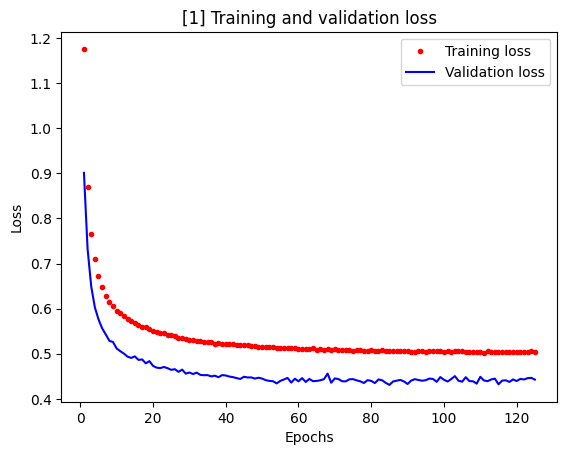

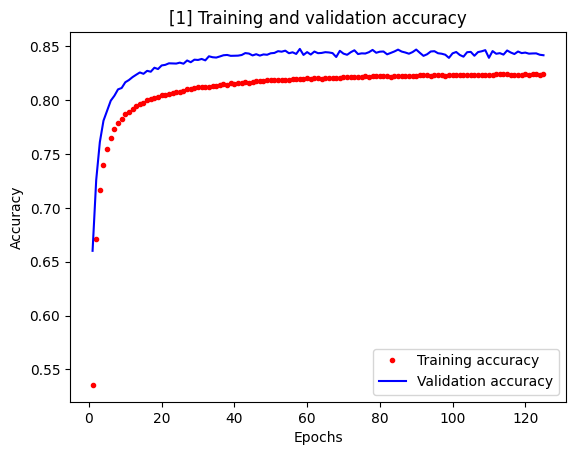

In [6]:
x_train = None
y_train = None
x_validate = None
y_validate = None
x_test = None
y_test = None
for stage in range(stage_count):
  (s_x_train, s_x_validate, s_x_test) = stage_x_dps[stage]
  (s_y_train, s_y_validate, s_y_test) = stage_y_dps[stage]
  if stage == 0:
    x_train = s_x_train
    y_train = s_y_train
    x_validate = s_x_validate
    y_validate = s_y_validate
    x_test = s_x_test
    y_test = s_y_test
  else:
    x_train = np.concatenate((x_train, s_x_train), axis=0)
    y_train = np.concatenate((y_train, s_y_train), axis=0)
    x_validate = np.concatenate((x_validate, s_x_validate), axis=0)     
    y_validate = np.concatenate((y_validate, s_y_validate), axis=0)
    x_test = np.concatenate((x_test, s_x_test), axis=0)
    y_test = np.concatenate((y_test, s_y_test), axis=0)

history = model.fit(x_train, y_train, batch_size=batch_size, epochs=epoch_count, verbose=1, validation_data=(x_validate, y_validate))

print(f"[{stage}] ====================")
evaluation = model.evaluate(x_test, y_test)
print(f"[{stage}] * evaluation {stage_round_counts}:{round_count}-{stage_step_count}/{epoch_count} -- {evaluation}")
print(f"[{stage}] ====================")

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, 'r.', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title(f'[{stage}] Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, 'r.', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'b', label='Validation accuracy')
plt.title(f'[{stage}] Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


In [7]:
for stage in range(stage_count):
  round_count = stage_round_counts[stage]
  (x_train, x_validate, x_test) = stage_x_dps[stage]
  (y_train, y_validate, y_test) = stage_y_dps[stage]
  print(f"[{stage}] $$$$$$$$$$$$$$$$$$$$")
  evaluation = model.evaluate(x_test, y_test)
  print(f"[{stage}] * evaluation {stage_round_counts}:{round_count}-{stage_step_count}/{epoch_count} -- {evaluation}")
  print(f"[{stage}] $$$$$$$$$$$$$$$$$$$$")


[0] $$$$$$$$$$$$$$$$$$$$
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8432 - loss: 0.4478
[0] * evaluation [10000, 20000]:10000-20/125 -- [0.4478358328342438, 0.8437749743461609]
[0] $$$$$$$$$$$$$$$$$$$$
[1] $$$$$$$$$$$$$$$$$$$$
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.8413 - loss: 0.4337
[1] * evaluation [10000, 20000]:20000-20/125 -- [0.43836987018585205, 0.8401874899864197]
[1] $$$$$$$$$$$$$$$$$$$$


In [8]:
for stage in range(stage_count):
  board_manager = BoardManager(tile_count)
  board_manager.randomize_board_step()
  board_manager.show_board()
  x = np.array([board_manager.board_tiles]).astype('float32') / (tile_count * tile_count)
  prediction = model.predict(x)[0]
  ans = argmax(prediction)
  print(f"[{stage}] * move [{ans}] -- {prediction}")

---------------------
|  1 |  0 |  2 |  3 |
|  4 |  5 |  6 |  7 |
|  8 |  9 | 10 | 11 |
| 12 | 13 | 14 | 15 |
---------------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
[0] * move [0] -- [9.8703092e-01 3.6981797e-03 5.7609927e-08 9.2666307e-03 3.8167875e-07
 3.5831217e-06 7.8973703e-12 3.1314468e-07]
---------------------
|  1 |  0 |  2 |  3 |
|  4 |  5 |  6 |  7 |
|  8 |  9 | 10 | 11 |
| 12 | 13 | 14 | 15 |
---------------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
[1] * move [0] -- [9.8703092e-01 3.6981797e-03 5.7609927e-08 9.2666307e-03 3.8167875e-07
 3.5831217e-06 7.8973703e-12 3.1314468e-07]


In [9]:
!mkdir output
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

header_name = f"sp_staged_model_{tile_count}_{stage_count}"
write_model_as_c_header_file(tflite_model, f"src/esp32_sliding_puzzle/{header_name}.h", "sp_model")

print()
print(f"***** {header_name}.h is generated *****")


A subdirectory or file output already exists.


INFO:tensorflow:Assets written to: C:\Users\TREVOR~1\AppData\Local\Temp\tmpdlqtl_jw\assets


INFO:tensorflow:Assets written to: C:\Users\TREVOR~1\AppData\Local\Temp\tmpdlqtl_jw\assets


Saved artifact at 'C:\Users\TREVOR~1\AppData\Local\Temp\tmpdlqtl_jw'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 16), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 8), dtype=tf.float32, name=None)
Captures:
  2502915786528: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2502915861488: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2502916065936: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2502916065584: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2502916118656: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2502916118480: TensorSpec(shape=(), dtype=tf.resource, name=None)

***** sp_staged_model_4_2.h is generated *****
